In [154]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from statsmodels.tsa.stattools import adfuller

# Loading Data

In [155]:
df = pd.read_csv("FinalProject-Singapore.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [156]:
cols_to_plot = ['STI_Price', 'SPY_Price', 'SHG_Price', 'US Interest Rates',
                'China Interest Rates ', 'Production Index United States',
                'Production Index China', 'CNY', 'USD']

#### D(1) - Returns Data

In [157]:
for col in cols_to_plot:
    df[f'{col}_returns'] = df[col].pct_change().fillna(0)

# Data Exploration

## Observing Data

#### Frequency Distribution

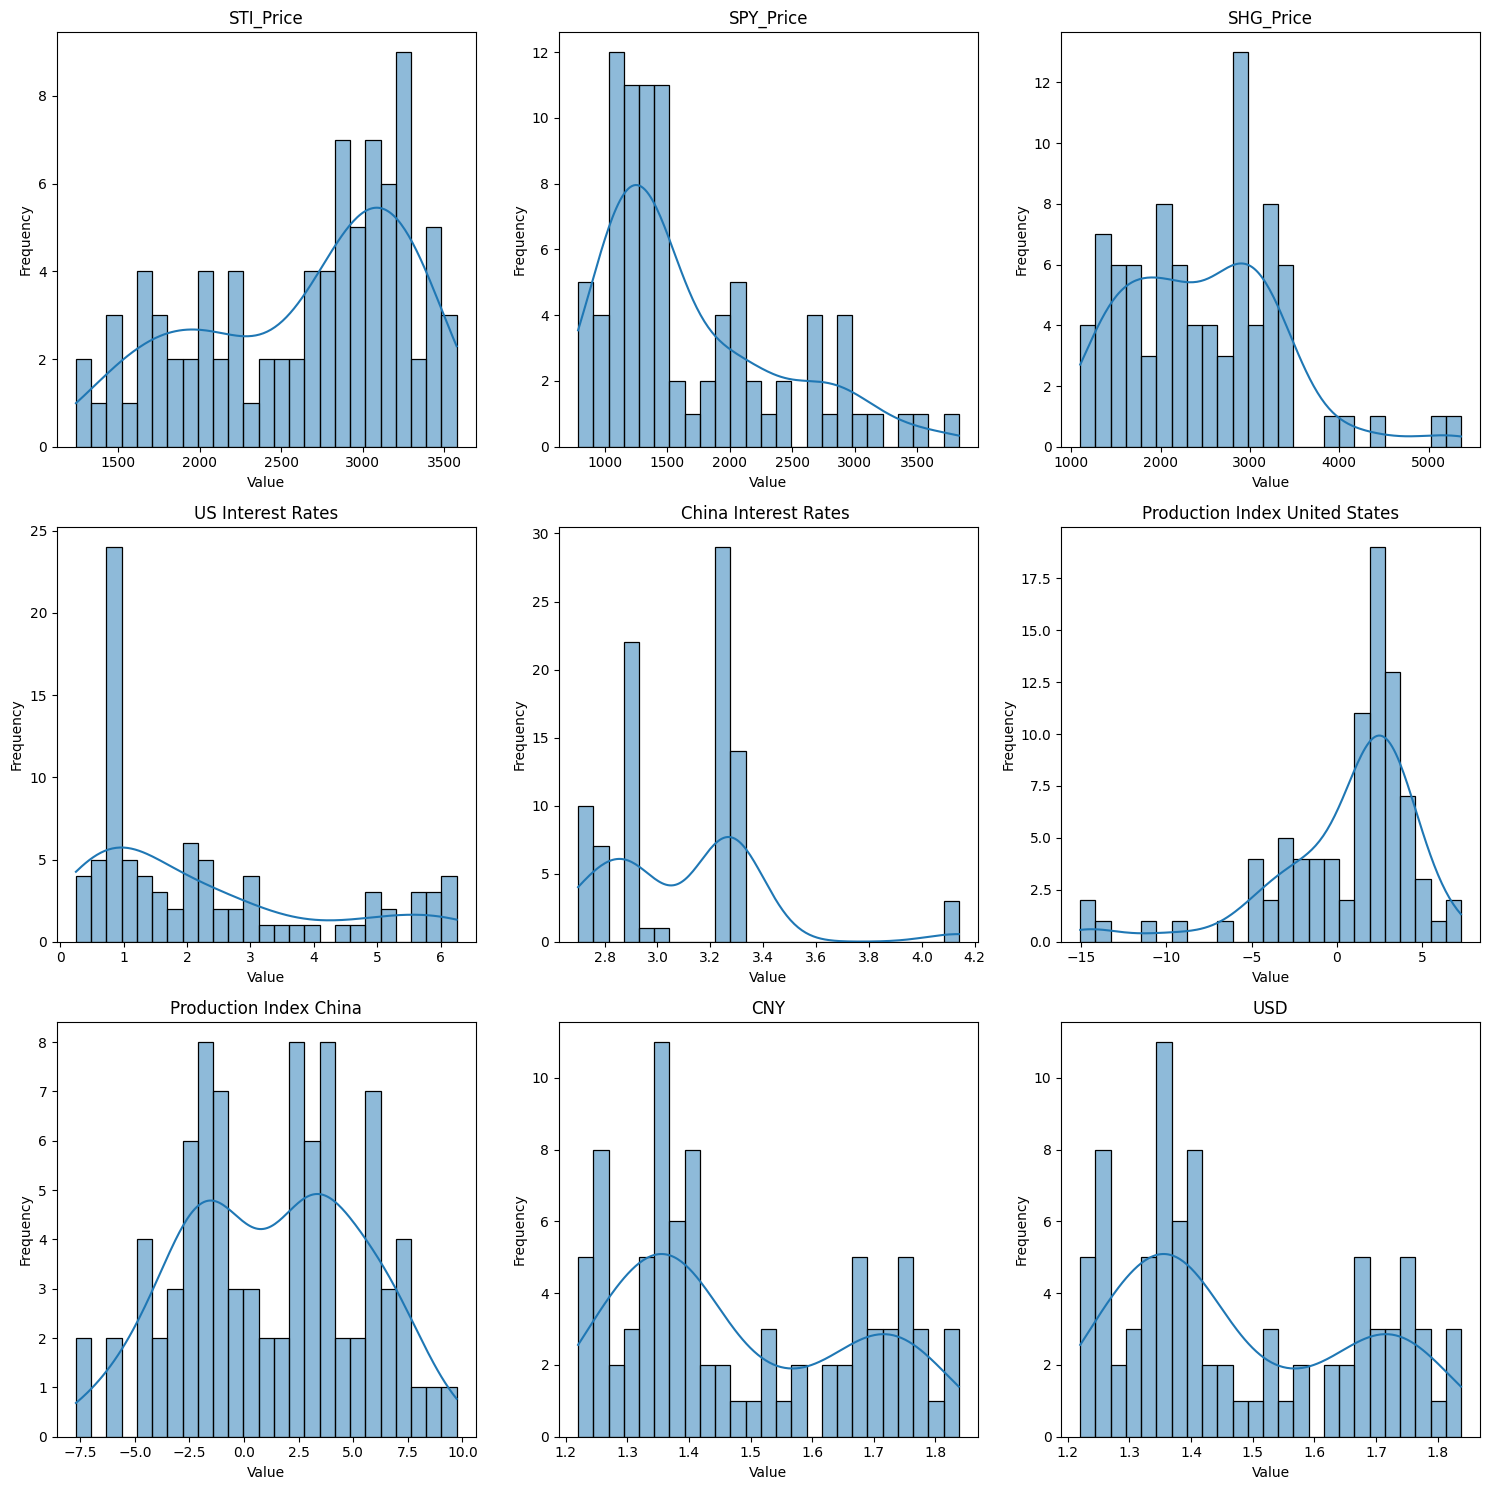

In [158]:


n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(cols_to_plot):
    sns.histplot(df[col], ax=axes[i], kde=True, bins=25)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# If there are any leftover axes, turn them off
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Over Time

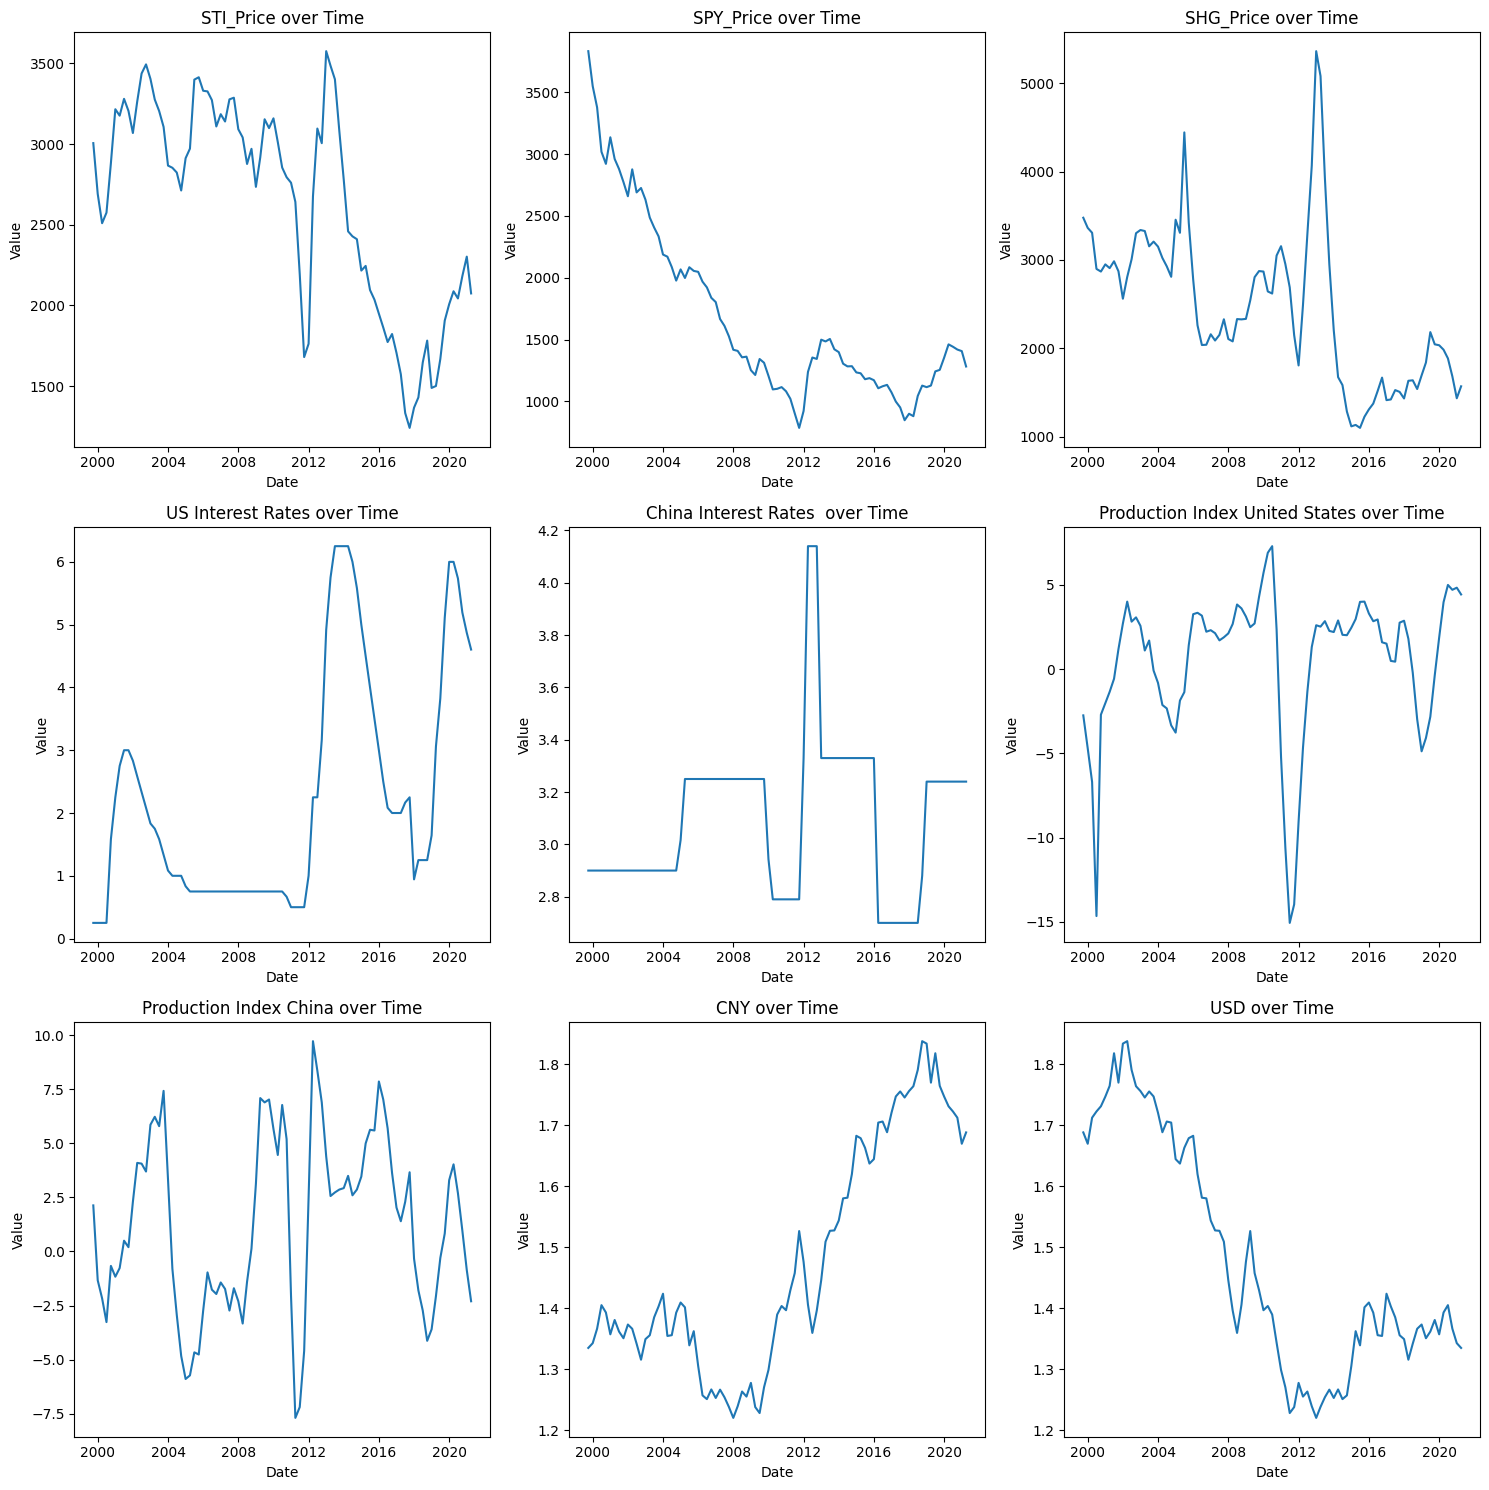

In [159]:


n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(cols_to_plot):
    sns.lineplot(x=df['Date'], y=df[col], ax=axes[i])
    axes[i].set_title(f"{col} over Time")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')

# If there are any leftover axes, turn them off
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Returns

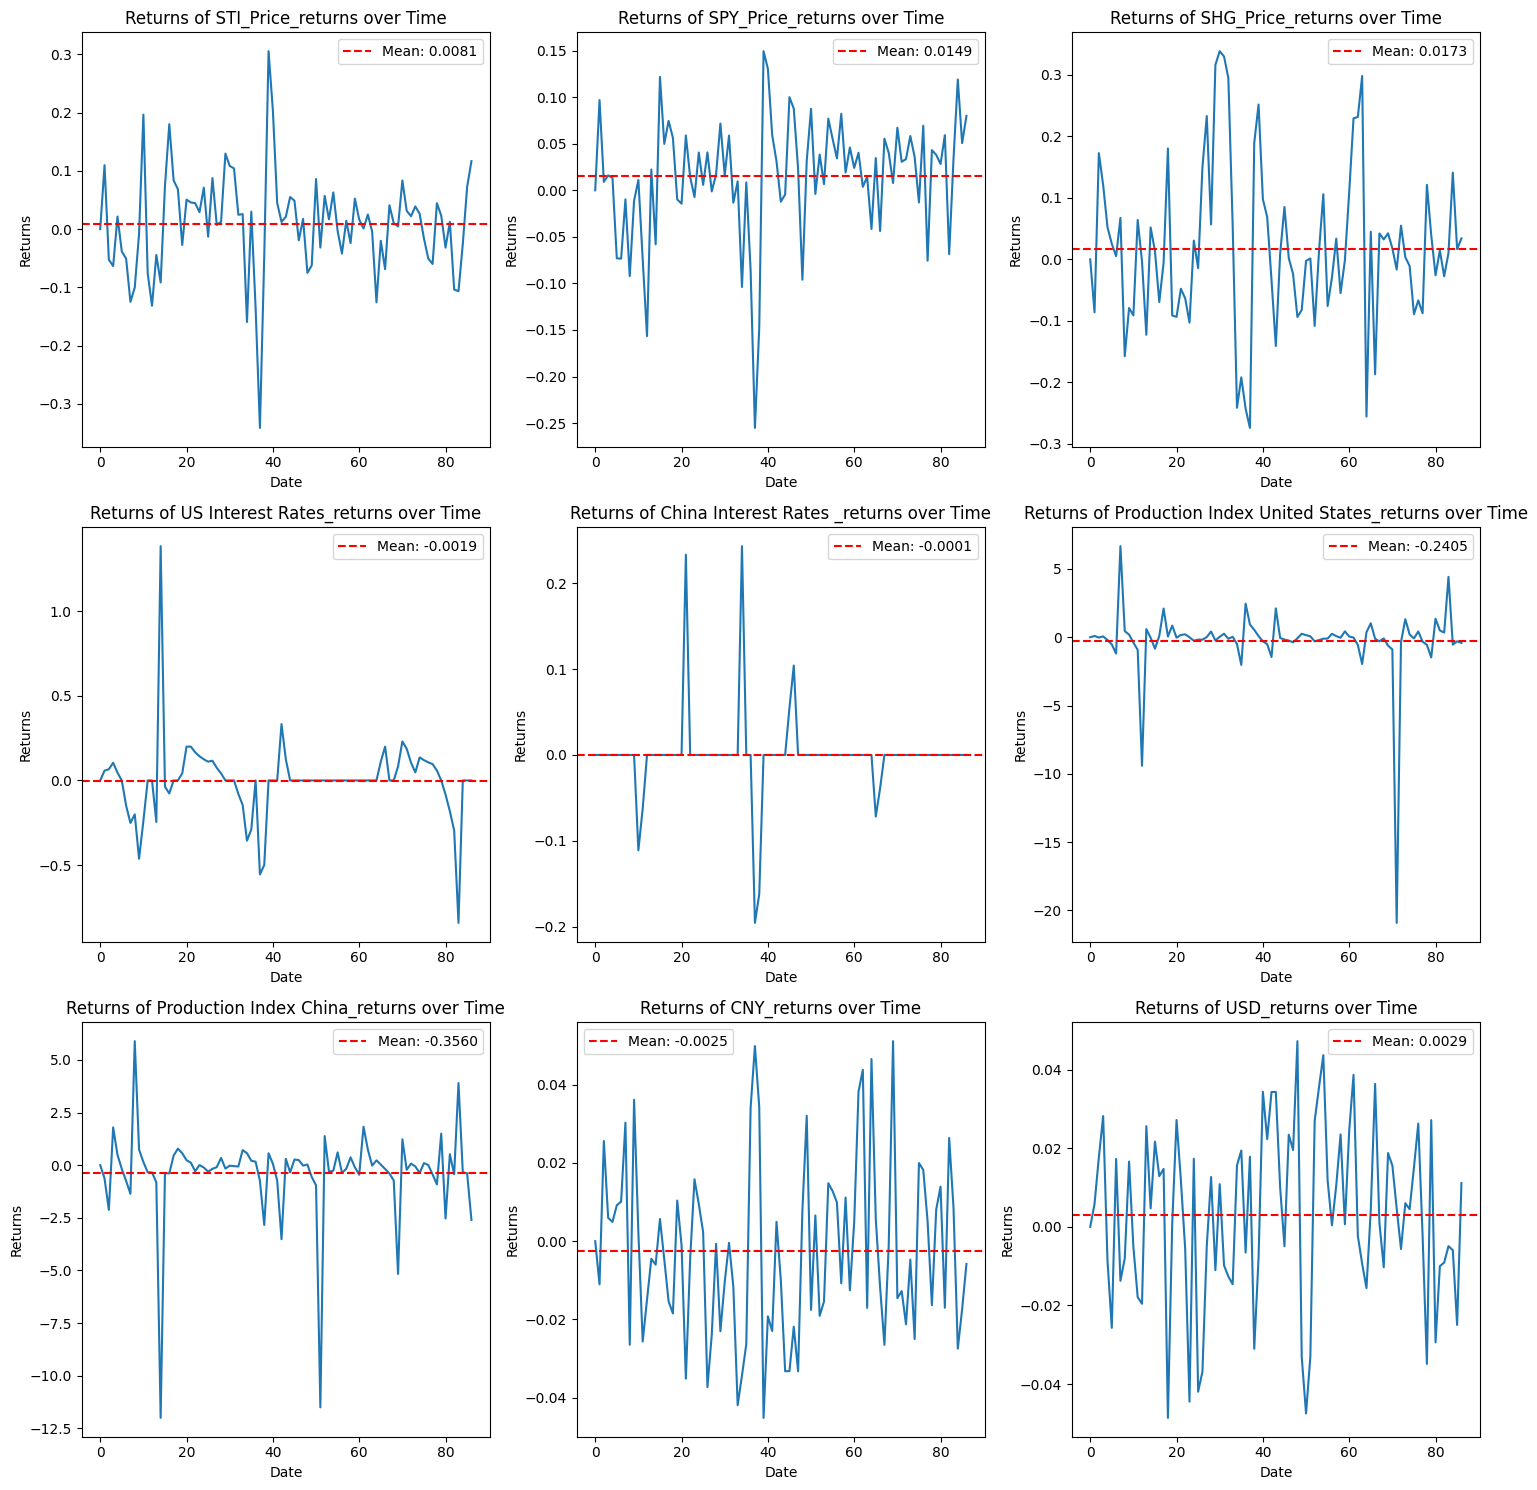

In [160]:

n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.lineplot(data=df, x=df.index, y=col+'_returns', ax=axes[i])
    mean_return = df[col+'_returns'].mean()  # Calculate the mean return for the column
    axes[i].axhline(mean_return, color='red', linestyle='--', label=f'Mean: {mean_return:.4f}')
    axes[i].set_title(f"Returns of {col+'_returns'} over Time")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Returns')
    axes[i].legend()  # Show the legend

# Remove any leftover axes
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Frequency Distribution - Returns

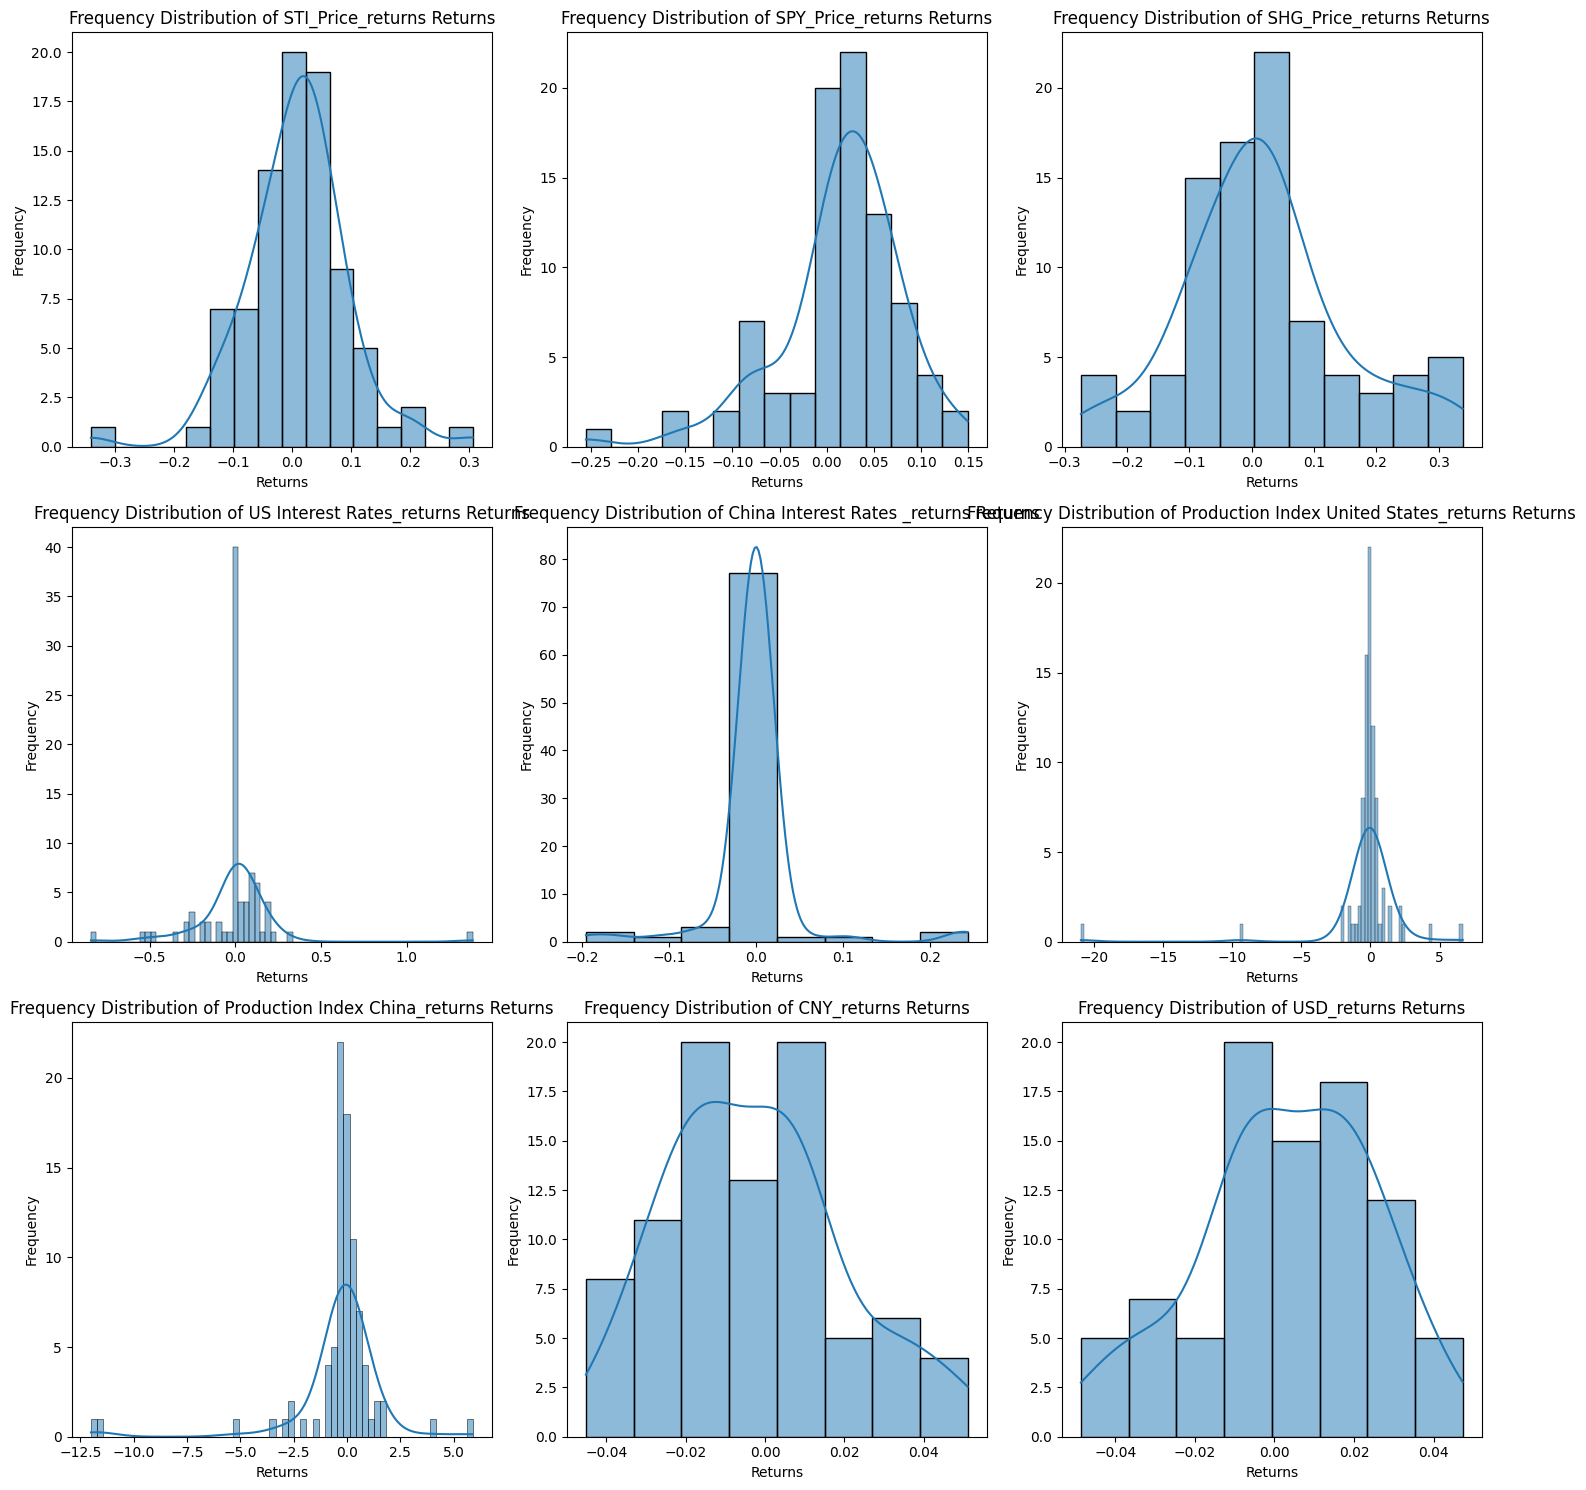

In [161]:
# Plotting frequency distributions
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.histplot(df[col+'_returns'], kde=True, ax=axes[i])  # You can use histplot for histograms
    axes[i].set_title(f"Frequency Distribution of {col+'_returns'} Returns")
    axes[i].set_xlabel('Returns')
    axes[i].set_ylabel('Frequency')

# Remove any leftover axes
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Unit Root Tests

In [162]:
def perform_adf_test(series):
    result = adfuller(series)
    return {'ADF Statistic': result[0], 'p-value': result[1], **result[4]}

# Initialize lists to hold test results
raw_data_results = []
returns_data_results = []

# Perform ADF test on raw data and returns data, store results in lists
for col in cols_to_plot:
    raw_data_results.append(perform_adf_test(df[col]))
    returns_data_results.append(perform_adf_test(df[col+"_returns"]))

# Convert results to DataFrames
adf_raw_data_df = pd.DataFrame(raw_data_results, index=cols_to_plot)
adf_returns_data_df = pd.DataFrame(returns_data_results, index=cols_to_plot)

# Display the DataFrames
print("ADF Test on Raw Data:")
adf_raw_data_df.sort_values(by="ADF Statistic")


ADF Test on Raw Data:


,ADF Statistic,p-value,1%,5%,10%
Production Index United States,-4.738997,0.000071,-3.510712,-2.896616,-2.585482
US Interest Rates,-3.702849,0.004073,-3.511712,-2.897048,-2.585713
China Interest Rates,-3.566120,0.006443,-3.509736,-2.896195,-2.585258
Production Index China,-2.570815,0.099180,-3.518281,-2.899878,-2.587223
STI_Price,-2.058086,0.261699,-3.509736,-2.896195,-2.585258
SHG_Price,-1.998478,0.287241,-3.512738,-2.897490,-2.585949
CNY,-1.189168,0.678238,-3.510712,-2.896616,-2.585482
USD,-0.731810,0.838337,-3.509736,-2.896195,-2.585258
SPY_Price,2.977513,1.000000,-3.508783,-2.895784,-2.585038


In [163]:
print("\nADF Test on Returns Data:")
adf_returns_data_df.sort_values(by="ADF Statistic")


ADF Test on Returns Data:


,ADF Statistic,p-value,1%,5%,10%
Production Index China,-9.380165,6.992015e-16,-3.508783,-2.895784,-2.585038
Production Index United States,-8.913760,1.086592e-14,-3.508783,-2.895784,-2.585038
USD,-7.637972,1.929603e-11,-3.508783,-2.895784,-2.585038
US Interest Rates,-7.257332,1.717181e-10,-3.508783,-2.895784,-2.585038
SPY_Price,-6.911232,1.210916e-09,-3.508783,-2.895784,-2.585038
STI_Price,-6.741941,3.102912e-09,-3.509736,-2.896195,-2.585258
CNY,-6.571515,7.914444e-09,-3.509736,-2.896195,-2.585258
China Interest Rates,-6.152980,7.484435e-08,-3.510712,-2.896616,-2.585482
SHG_Price,-5.366548,3.980530e-06,-3.511712,-2.897048,-2.585713


# Research